In [7]:
import os
import json
import random
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import numpy as np

# Disable TensorFlow if not needed
os.environ["TRANSFORMERS_NO_TF"] = "1"

# Load data for clustering
with open('extracted_events_4omini.json', 'r') as f:
    data = json.load(f)

# Flatten nested lists of entries into a single list of dictionaries
flattened_data = []
for entry in data:
    if isinstance(entry, list):
        flattened_data.extend(entry)
    elif isinstance(entry, dict):
        flattened_data.append(entry)

# Sample the data if it's very large (optional)
sample_size = min(len(flattened_data), 100)
sampled_data = random.sample(flattened_data, sample_size)

# Prepare clustering-focused data for the sampled entries
texts_for_clustering = [
    f"{entry.get('Phrase Summary', '')} {' '.join(entry.get('Keywords', []))}" for entry in sampled_data
]

# Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts_for_clustering)

# Reduce dimensionality for faster clustering
pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(embeddings)

# Apply HDBSCAN for primary clustering
primary_clustering_model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3, metric='euclidean')
primary_labels = primary_clustering_model.fit_predict(reduced_embeddings)

# Group sampled data by primary clusters
primary_clusters = {}
for idx, label in enumerate(primary_labels):
    if label == -1:
        continue  # Ignore noise points (label = -1)
    if label not in primary_clusters:
        primary_clusters[label] = []
    primary_clusters[label].append(sampled_data[idx])

# Check if any clusters were formed
if not primary_clusters:
    raise ValueError("No clusters were formed by HDBSCAN. Adjust clustering parameters.")

# Optional: Assign remaining data to the closest primary cluster (approximate)
remaining_data = [entry for entry in flattened_data if entry not in sampled_data]

# Create centroids for each cluster in primary_clusters
cluster_centroids = {}
for label, events in primary_clusters.items():
    event_texts = [f"{event.get('Phrase Summary', '')} {' '.join(event.get('Keywords', []))}" for event in events]
    event_embeddings = model.encode(event_texts)
    reduced_event_embeddings = pca.transform(event_embeddings)
    cluster_centroids[label] = reduced_event_embeddings.mean(axis=0)

# Check if centroids were created
if not cluster_centroids:
    raise ValueError("Cluster centroids were not created. Check if primary clusters are correctly populated.")

# Assign remaining data to the closest cluster based on centroids
assigned_clusters = {label: primary_clusters[label] for label in primary_clusters}
for entry in remaining_data:
    entry_text = f"{entry.get('Phrase Summary', '')} {' '.join(entry.get('Keywords', []))}"
    entry_embedding = model.encode([entry_text])
    reduced_entry_embedding = pca.transform(entry_embedding)

    # Find the closest cluster centroid
    closest_label = min(
        cluster_centroids,
        key=lambda label: np.linalg.norm(reduced_entry_embedding - cluster_centroids[label])
    )
    assigned_clusters[closest_label].append(entry)

# assigned_clusters now contains the primary clusters with additional data assigned


Total flattened data entries: 4460
Sampled data size: 100
Number of texts prepared for clustering: 100
Generated embeddings shape: (100, 384)
Reduced embeddings shape: (100, 100)


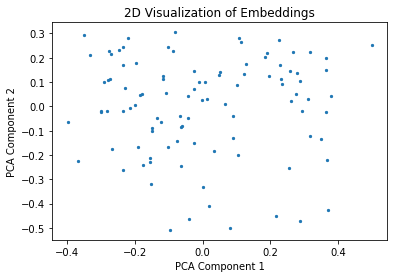

Attempting HDBSCAN clustering...
HDBSCAN labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, -1}
Number of primary clusters formed by HDBSCAN: 22
Attempting DBSCAN clustering...
No clusters were formed by DBSCAN.
Attempting KMeans clustering...
Number of clusters formed by KMeans: 5
Number of cluster centroids created: 22
Total assigned clusters (with additional data): 22
Cluster 6 has 44 entries.
Cluster 1 has 36 entries.
Cluster 17 has 21 entries.

Cluster 6 sample entries:
{'Video ID': 'vgD1tVd9ubA', 'Entry Type': 'Belief or Opinion', 'Date/Time': '2011-12-17', 'Phrase Summary': 'Grateful for community support and contributions', 'Location': '64-68'}
{'Video ID': 'xHfYj48mDCY', 'Entry Type': 'Belief or Opinion', 'Date/Time': 'January 19, 2016', 'Phrase Summary': 'Grateful for previous successful adaptations', 'Location': '45-48'}
{'Video ID': '1sX0PjAd3-Q', 'Entry Type': 'Belief or Opinion', 'Date/Time': 'January 2nd, 2024', 'Phrase Summary': "Grat

In [2]:
import os
import json
import random
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
import numpy as np
import matplotlib.pyplot as plt

# Disable TensorFlow if not needed
os.environ["TRANSFORMERS_NO_TF"] = "1"

# Load data for clustering
with open('extracted_events_4omini.json', 'r') as f:
    data = json.load(f)

# Flatten nested lists of entries into a single list of dictionaries
flattened_data = []
for entry in data:
    if isinstance(entry, list):
        flattened_data.extend(entry)
    elif isinstance(entry, dict):
        flattened_data.append(entry)

print(f"Total flattened data entries: {len(flattened_data)}")

# Sample the data if it's very large (optional)
sample_size = min(len(flattened_data), 100)
sampled_data = random.sample(flattened_data, sample_size)
print(f"Sampled data size: {len(sampled_data)}")

# Prepare clustering-focused data for the sampled entries
texts_for_clustering = [
    f"{entry.get('Phrase Summary', '')} {' '.join(entry.get('Keywords', []))}" for entry in sampled_data
]
print(f"Number of texts prepared for clustering: {len(texts_for_clustering)}")

# Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts_for_clustering)
print(f"Generated embeddings shape: {embeddings.shape}")

# Option to skip PCA or adjust the number of components
use_pca = True  # Set to False to skip PCA
pca_components = 100  # Adjust this number or skip PCA if necessary

if use_pca:
    pca = PCA(n_components=pca_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    print(f"Reduced embeddings shape: {reduced_embeddings.shape}")
else:
    reduced_embeddings = embeddings
    print("PCA skipped; using original embedding dimensions.")

# Visualize data in 2D to understand distribution
pca_visualization = PCA(n_components=2)
visual_embeddings = pca_visualization.fit_transform(reduced_embeddings)
plt.scatter(visual_embeddings[:, 0], visual_embeddings[:, 1], s=5)
plt.title("2D Visualization of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Attempt HDBSCAN clustering
print("Attempting HDBSCAN clustering...")
primary_clustering_model = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, metric='euclidean')
primary_labels = primary_clustering_model.fit_predict(reduced_embeddings)
print(f"HDBSCAN labels: {set(primary_labels)}")

# Check if any clusters were formed by HDBSCAN
primary_clusters = {}
for idx, label in enumerate(primary_labels):
    if label == -1:
        continue  # Ignore noise points (label = -1)
    if label not in primary_clusters:
        primary_clusters[label] = []
    primary_clusters[label].append(sampled_data[idx])

if primary_clusters:
    print(f"Number of primary clusters formed by HDBSCAN: {len(primary_clusters)}")
else:
    print("No clusters were formed by HDBSCAN. Trying alternative clustering methods...")

# Alternative 1: DBSCAN clustering
print("Attempting DBSCAN clustering...")
dbscan_model = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
dbscan_labels = dbscan_model.fit_predict(reduced_embeddings)
dbscan_clusters = {label: [] for label in set(dbscan_labels) if label != -1}
for idx, label in enumerate(dbscan_labels):
    if label != -1:
        dbscan_clusters[label].append(sampled_data[idx])

if dbscan_clusters:
    print(f"Number of clusters formed by DBSCAN: {len(dbscan_clusters)}")
else:
    print("No clusters were formed by DBSCAN.")

# Alternative 2: KMeans clustering
print("Attempting KMeans clustering...")
num_clusters = 5  # Adjust as necessary
kmeans_model = KMeans(n_clusters=num_clusters)
kmeans_labels = kmeans_model.fit_predict(reduced_embeddings)
kmeans_clusters = {label: [] for label in set(kmeans_labels)}
for idx, label in enumerate(kmeans_labels):
    kmeans_clusters[label].append(sampled_data[idx])

print(f"Number of clusters formed by KMeans: {len(kmeans_clusters)}")

# Create cluster centroids for HDBSCAN or DBSCAN if clusters were found, and assign remaining data
selected_clusters = primary_clusters if primary_clusters else (dbscan_clusters if dbscan_clusters else kmeans_clusters)
cluster_centroids = {}
for label, events in selected_clusters.items():
    event_texts = [f"{event.get('Phrase Summary', '')} {' '.join(event.get('Keywords', []))}" for event in events]
    event_embeddings = model.encode(event_texts)
    reduced_event_embeddings = pca.transform(event_embeddings) if use_pca else event_embeddings
    cluster_centroids[label] = reduced_event_embeddings.mean(axis=0)

print(f"Number of cluster centroids created: {len(cluster_centroids)}")

# Assign remaining data to the closest cluster based on centroids
remaining_data = [entry for entry in flattened_data if entry not in sampled_data]
assigned_clusters = {label: selected_clusters[label] for label in selected_clusters}
for entry in remaining_data:
    entry_text = f"{entry.get('Phrase Summary', '')} {' '.join(entry.get('Keywords', []))}"
    entry_embedding = model.encode([entry_text])
    reduced_entry_embedding = pca.transform(entry_embedding) if use_pca else entry_embedding

    # Find the closest cluster centroid
    closest_label = min(
        cluster_centroids,
        key=lambda label: np.linalg.norm(reduced_entry_embedding - cluster_centroids[label])
    )
    assigned_clusters[closest_label].append(entry)

print(f"Total assigned clusters (with additional data): {len(assigned_clusters)}")

# Display sample of the clustered data for verification
for label, events in list(assigned_clusters.items())[:3]:  # Display only the first 3 clusters for brevity
    print(f"Cluster {label} has {len(events)} entries.")

# Display a sample of entries from each cluster for verification
for label, events in list(assigned_clusters.items())[:3]:  # Limit to the first 3 clusters
    print(f"\nCluster {label} sample entries:")
    for event in events[:5]:  # Show first 5 entries as a sample
        print(event)


# Assign remaining data to the closest cluster based on centroids
remaining_data = [entry for entry in flattened_data if entry not in sampled_data]
assigned_clusters = {label: selected_clusters[label] for label in selected_clusters}
for entry in remaining_data:
    entry_text = f"{entry.get('Phrase Summary', '')} {' '.join(entry.get('Keywords', []))}"
    entry_embedding = model.encode([entry_text])
    reduced_entry_embedding = pca.transform(entry_embedding) if use_pca else entry_embedding

    # Find the closest cluster centroid
    closest_label = min(
        cluster_centroids,
        key=lambda label: np.linalg.norm(reduced_entry_embedding - cluster_centroids[label])
    )
    assigned_clusters[closest_label].append(entry)

print(f"Total assigned clusters (with additional data): {len(assigned_clusters)}")

# Display sample of the clustered data for verification
for label, events in list(assigned_clusters.items())[:3]:  # Display only the first 3 clusters for brevity
    print(f"Cluster {label} has {len(events)} entries.")

# Display a sample of entries from each cluster for verification
for label, events in list(assigned_clusters.items())[:3]:  # Limit to the first 3 clusters
    print(f"\nCluster {label} sample entries:")
    for event in events[:5]:  # Show first 5 entries as a sample
        print(event)

# Generate descriptive names for each cluster
from collections import Counter

# Function to get a cluster name based on common terms
def generate_cluster_name(cluster_data):
    phrase_summaries = [entry.get('Phrase Summary', '') for entry in cluster_data]
    entry_types = [entry.get('Entry Type', '') for entry in cluster_data]

    # Combine all phrase summaries and entry types into one text for term frequency analysis
    combined_text = " ".join(phrase_summaries) + " " + " ".join(entry_types)
    words = combined_text.split()
    # Filter out common stopwords and single characters (like punctuation)
    stopwords = {"the", "a", "and", "of", "for", "in", "on", "to", "with", "is", "", "it", "by", "as"}
    filtered_words = [word.lower() for word in words if word.lower() not in stopwords and len(word) > 1]

    # Get the most common words in the combined text
    most_common_words = Counter(filtered_words).most_common(3)  # Get top 3 words
    common_words_str = " ".join([word for word, _ in most_common_words])

    # Get the most common entry type
    common_entry_type = Counter(entry_types).most_common(1)[0][0] if entry_types else "Miscellaneous"

    # Generate a descriptive cluster name
    return f"{common_entry_type} - {common_words_str}"

# Assign names to each cluster based on the common terms
cluster_names = {}
for label, events in assigned_clusters.items():
    cluster_name = generate_cluster_name(events)
    cluster_names[label] = cluster_name

# Print out the cluster names for verification
print("\nDescriptive Cluster Names:")
for label, name in cluster_names.items():
    print(f"Cluster {label}: {name}")

In [6]:
import os
import json
import random
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Disable TensorFlow if not needed
os.environ["TRANSFORMERS_NO_TF"] = "1"

# Load data for clustering
with open('extracted_events_4omini.json', 'r') as f:
    data = json.load(f)

# Flatten nested lists of entries into a single list of dictionaries
flattened_data = []
for entry in data:
    if isinstance(entry, list):
        flattened_data.extend(entry)
    elif isinstance(entry, dict):
        flattened_data.append(entry)

print(f"Total flattened data entries: {len(flattened_data)}")

# Increase sample size to better capture variety in top-level clustering
sample_size = min(len(flattened_data), 1000)
sampled_data = random.sample(flattened_data, sample_size)
print(f"Sampled data size: {len(sampled_data)}")

# Prepare clustering-focused data for the sampled entries
texts_for_clustering = [
    f"{entry.get('Phrase Summary', '')} {' '.join(entry.get('Keywords', []))}" for entry in sampled_data
]
print(f"Number of texts prepared for clustering: {len(texts_for_clustering)}")

# Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts_for_clustering)
print(f"Generated embeddings shape: {embeddings.shape}")

# Option to skip PCA or adjust the number of components
use_pca = True
pca_components = 50  # Reduced components for broader clustering

if use_pca:
    pca = PCA(n_components=pca_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    print(f"Reduced embeddings shape: {reduced_embeddings.shape}")
else:
    reduced_embeddings = embeddings
    print("PCA skipped; using original embedding dimensions.")

# Use KMeans to create approximately 10-15 broad top-level clusters
print("Performing top-level clustering with KMeans to identify broad topics...")
top_level_clustering_model = KMeans(n_clusters=10, random_state=0)  # Reduced cluster count
top_level_labels = top_level_clustering_model.fit_predict(reduced_embeddings)
print(f"Top-Level KMeans labels: {set(top_level_labels)}")

# Organize entries by top-level clusters
top_level_clusters = {}
for idx, label in enumerate(top_level_labels):
    if label not in top_level_clusters:
        top_level_clusters[label] = []
    top_level_clusters[label].append(sampled_data[idx])

# Function to extract main themes using TF-IDF
def extract_main_terms(cluster_data, num_terms=3):
    phrase_summaries = [entry.get('Phrase Summary', '') for entry in cluster_data]
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(phrase_summaries)
    indices = np.argsort(np.asarray(X.sum(axis=0)).ravel())[::-1]
    feature_names = vectorizer.get_feature_names_out()
    main_terms = [feature_names[i] for i in indices[:num_terms]]
    return " | ".join(main_terms)

# Generate names for top-level clusters based on extracted main terms
top_level_cluster_names = {}
for label, events in top_level_clusters.items():
    top_level_cluster_names[label] = extract_main_terms(events)

# Display the names for broad clusters
print("\nTop-Level Cluster Names:")
for label, name in top_level_cluster_names.items():
    print(f"Cluster {label}: {name}")

# Step 3: Sub-Clustering within Each Broad Cluster for More Granular Topics
sub_clusters = {}
sub_cluster_names = {}
for label, events in top_level_clusters.items():
    print(f"\nSub-clustering within top-level cluster {label} ({top_level_cluster_names[label]})...")
    event_texts = [f"{event.get('Phrase Summary', '')} {' '.join(event.get('Keywords', []))}" for event in events]
    event_embeddings = model.encode(event_texts)
    reduced_event_embeddings = pca.transform(event_embeddings) if use_pca else event_embeddings

    # Apply HDBSCAN for sub-clustering
    sub_clustering_model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric='euclidean')
    sub_labels = sub_clustering_model.fit_predict(reduced_event_embeddings)
    sub_clusters[label] = {}

    for idx, sub_label in enumerate(sub_labels):
        if sub_label == -1:
            continue
        if sub_label not in sub_clusters[label]:
            sub_clusters[label][sub_label] = []
        sub_clusters[label][sub_label].append(events[idx])

    # Generate names for sub-clusters based on main terms
    sub_cluster_names[label] = {}
    for sub_label, sub_events in sub_clusters[label].items():
        sub_cluster_names[label][sub_label] = extract_main_terms(sub_events)

# Display sub-cluster names for each top-level cluster
print("\nSub-Cluster Names within Each Top-Level Cluster:")
for label, sub_dict in sub_cluster_names.items():
    print(f"\nTop-Level Cluster {label} ({top_level_cluster_names[label]}):")
    for sub_label, sub_name in sub_dict.items():
        print(f"  Sub-Cluster {sub_label}: {sub_name}")


Total flattened data entries: 4460
Sampled data size: 1000
Number of texts prepared for clustering: 1000
Generated embeddings shape: (1000, 384)
Reduced embeddings shape: (1000, 50)
Performing top-level clustering with KMeans to identify broad topics...
Top-Level KMeans labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Top-Level Cluster Names:
Cluster 8: life | value | importance
Cluster 2: announces | new | announced
Cluster 7: celebrated | celebrates | family
Cluster 0: expresses | gratitude | community
Cluster 6: youtube | internet | video
Cluster 1: critiques | expresses | advocates
Cluster 3: reflects | importance | art
Cluster 5: book | release | announces
Cluster 9: charity | 000 | raised
Cluster 4: health | cancer | healthcare

Sub-clustering within top-level cluster 8 (life | value | importance)...

Sub-clustering within top-level cluster 2 (announces | new | announced)...

Sub-clustering within top-level cluster 7 (celebrated | celebrates | family)...

Sub-clustering within top-level c

In [25]:
import os
import json
import random
import torch
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline

# Configure GPU usage if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0 if device == "cuda" else -1)

# Load data
with open('extracted_events_4omini.json', 'r') as f:
    data = json.load(f)
    

# Flatten nested lists of entries into a single list of dictionaries
flattened_data = []
for entry in data:
    if isinstance(entry, list):
        flattened_data.extend(entry)
    elif isinstance(entry, dict):
        flattened_data.append(entry)

print(f"Total flattened data entries: {len(flattened_data)}")

# Sample data if it's very large
sample_size = min(len(flattened_data), 1000)
sampled_data = random.sample(flattened_data, sample_size)
texts_for_clustering = [
    f"{entry.get('Phrase Summary', '')} {' '.join(entry.get('Keywords', []))}" for entry in sampled_data
]
embeddings = model.encode(texts_for_clustering)

# Reduce dimensions with PCA for better clustering performance
pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(embeddings)

# Top-Level Clustering for Main Wiki Pages
num_top_clusters = 30  # Set for 30–50 as required
top_level_model = KMeans(n_clusters=num_top_clusters)
top_labels = top_level_model.fit_predict(reduced_embeddings)

# Group data by top-level clusters
top_level_clusters = {label: [] for label in set(top_labels)}
for idx, label in enumerate(top_labels):
    top_level_clusters[label].append(sampled_data[idx])

# Generate meaningful summaries for top-level clusters
top_level_cluster_names = {}
for label, events in top_level_clusters.items():
    concatenated_text = " ".join([entry.get('Phrase Summary', '') for entry in events])

    # Dynamic summary length control
    input_length = len(concatenated_text.split())
    max_len = min(100, max(20, input_length // 3))  # Adjust as needed for coherence

    try:
        summary = summarizer(concatenated_text, max_length=max_len, min_length=max(10, max_len // 2), do_sample=False)[0]['summary_text']
    except IndexError:
        summary = concatenated_text[:100]  # Fallback for very short text

    top_level_cluster_names[label] = summary

# Step 2: Sub-Clustering within Each Top-Level Cluster with Theme Filtering
sub_clusters = {}
sub_cluster_summaries = {}
sub_cluster_counts = []

for label, events in top_level_clusters.items():
    top_level_theme = top_level_cluster_names[label]

    # Filter entries closely related to the top-level theme
    filtered_events = []
    for event in events:
        event_text = f"{event.get('Phrase Summary', '')} {' '.join(event.get('Keywords', []))}"
        similarity_score = model.encode([top_level_theme])[0] @ model.encode([event_text])[0]
        if similarity_score > 0.7:
            filtered_events.append(event)

    # Proceed with sub-clustering if there are enough filtered events
    if len(filtered_events) > 5:
        event_texts = [f"{event.get('Phrase Summary', '')} {' '.join(event.get('Keywords', []))}" for event in filtered_events]
        event_embeddings = model.encode(event_texts)
        reduced_event_embeddings = pca.transform(event_embeddings)

        # Apply HDBSCAN for sub-clustering
        sub_clustering_model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
        sub_labels = sub_clustering_model.fit_predict(reduced_event_embeddings)

        # Count and store sub-clusters
        sub_cluster_count = len(set(sub_labels)) - (1 if -1 in sub_labels else 0)
        sub_cluster_counts.append(sub_cluster_count)
        sub_clusters[label] = {}

        for idx, sub_label in enumerate(sub_labels):
            if sub_label == -1:
                continue
            if sub_label not in sub_clusters[label]:
                sub_clusters[label][sub_label] = []
            sub_clusters[label][sub_label].append(filtered_events[idx])

        # Generate summaries for sub-clusters
        sub_cluster_summaries[label] = {}
        for sub_label, sub_events in sub_clusters[label].items():
            sub_text = " ".join([event.get('Phrase Summary', '') for event in sub_events])
            input_length = len(sub_text.split())
            max_len = min(50, max(10, input_length // 2))

            try:
                summary = summarizer(sub_text, max_length=max_len, min_length=max(5, max_len // 2), do_sample=False)[0]['summary_text']
            except IndexError:
                summary = sub_text[:100]
            sub_cluster_summaries[label][sub_label] = summary
    else:
        sub_clusters[label] = {0: filtered_events}
        sub_cluster_summaries[label] = {}
        concatenated_text = " ".join([event.get('Phrase Summary', '') for event in filtered_events])
        summary = summarizer(concatenated_text, max_length=50, min_length=10, do_sample=False)[0]['summary_text']
        sub_cluster_summaries[label][0] = summary
        sub_cluster_counts.append(1)

# Step 3: Visualize top-level clusters with sub-cluster counts
cluster_names = list(top_level_cluster_names.values())
if len(sub_cluster_counts) < len(cluster_names):
    sub_cluster_counts.extend([0] * (len(cluster_names) - len(sub_cluster_counts)))

plt.figure(figsize=(12, 8))
plt.barh(cluster_names, sub_cluster_counts, color='skyblue')
plt.xlabel("Number of Sub-Clusters (Sections)")
plt.ylabel("Broad Topics for Wiki Pages")
plt.title("Number of Sub-Clusters within Each Broad Topic (for Wiki Pages)")
plt.gca().invert_yaxis()
plt.show()

# Print a structured summary for wiki page content
print("\nStructured Wiki Page Summary:")
for label, theme in top_level_cluster_names.items():
    print(f"\nTop-Level Wiki Page: {theme}")
    print("Sub-Topics (for subsections on the wiki page):")
    for sub_label, summary in list(sub_cluster_summaries[label].items())[:5]:  # Show top 5 sub-clusters as examples
        print(f"  - {summary}")


<_io.TextIOWrapper name='extracted_events_4omini.json' mode='r' encoding='UTF-8'>
Total flattened data entries: 4460


KeyboardInterrupt: 

MOST UPDATED

In [42]:
import os
import json
import torch
import umap
import hdbscan
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from collections import Counter
import matplotlib.pyplot as plt
import nltk
import re
import spacy

import umap.umap_ as umap


# Load the spaCy English model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Extract lemmatized tokens, removing stopwords and non-alphabetic tokens
    words = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(words)


def get_representative_texts(texts, max_length=512):
    combined_text = ' '.join(texts)
    words = combined_text.split()
    if len(words) > max_length:
        return ' '.join(words[:max_length])
    else:
        return combined_text

# Configure GPU usage if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load models
embedding_model = SentenceTransformer('all-mpnet-base-v2', device=device)
summarizer = pipeline("summarization", model="google/pegasus-xsum", device=0 if device == "cuda" else -1)

# Load data
with open('vlogbrothers_videos.json', 'r') as f:
    data = json.load(f)

# Extract transcripts and preprocess them
texts_for_clustering = []
entries_for_clustering = []

for entry in data:
    transcript = entry.get('transcript', '')
    if transcript:
        preprocessed_text = preprocess_text(transcript)
        texts_for_clustering.append(preprocessed_text)
        entries_for_clustering.append(entry)

print(f"Total entries loaded: {len(entries_for_clustering)}")

# Generate embeddings
print("Generating embeddings...")
embeddings = embedding_model.encode(texts_for_clustering, show_progress_bar=True)

# Dimensionality reduction with UMAP
print("Reducing dimensionality with UMAP...")
reducer = umap.UMAP(n_neighbors=15, n_components=50, metric='cosine')
reduced_embeddings = reducer.fit_transform(embeddings)

# Top-Level Clustering using Agglomerative Clustering
print("Performing top-level clustering...")
num_top_clusters = 30  # Adjust the number of clusters as needed
top_level_model = AgglomerativeClustering(n_clusters=num_top_clusters, affinity='euclidean', linkage='ward')
top_labels = top_level_model.fit_predict(reduced_embeddings)

# Group data by top-level clusters
top_level_clusters = {label: [] for label in set(top_labels)}
for idx, label in enumerate(top_labels):
    top_level_clusters[label].append(entries_for_clustering[idx])

# Generate summaries for top-level clusters
print("Generating summaries for top-level clusters...")
top_level_cluster_names = {}
for label, entries in top_level_clusters.items():
    texts = [entry.get('transcript', '') for entry in entries]
    representative_text = get_representative_texts(texts)
    summary = summarizer(representative_text, max_length=60, min_length=30, do_sample=False)[0]['summary_text']
    top_level_cluster_names[label] = summary

# Sub-Clustering within Each Top-Level Cluster
print("Performing sub-clustering within top-level clusters...")
sub_clusters = {}
sub_cluster_summaries = {}
for label, entries in top_level_clusters.items():
    texts = [preprocess_text(entry.get('transcript', '')) for entry in entries]
    if len(texts) < 5:
        # Not enough data to perform sub-clustering
        sub_clusters[label] = {0: entries}
        sub_cluster_summaries[label] = {}
        summary = top_level_cluster_names[label]
        sub_cluster_summaries[label][0] = summary
        continue

    # Generate embeddings for sub-clustering
    embeddings = embedding_model.encode(texts, show_progress_bar=False)
    reduced_embeddings = reducer.transform(embeddings)

    # Sub-clustering using HDBSCAN
    sub_clustering_model = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean')
    sub_labels = sub_clustering_model.fit_predict(reduced_embeddings)

    # Group entries by sub-cluster labels
    cluster_dict = {}
    for idx, sub_label in enumerate(sub_labels):
        if sub_label == -1:
            continue  # Skip noise points if any
        if sub_label not in cluster_dict:
            cluster_dict[sub_label] = []
        cluster_dict[sub_label].append(entries[idx])

    # Generate summaries for sub-clusters
    sub_clusters[label] = cluster_dict
    summaries = {}
    for sub_label, sub_entries in cluster_dict.items():
        sub_texts = [entry.get('transcript', '') for entry in sub_entries]
        representative_text = get_representative_texts(sub_texts)
        summary = summarizer(representative_text, max_length=50, min_length=25, do_sample=False)[0]['summary_text']
        summaries[sub_label] = summary
    sub_cluster_summaries[label] = summaries

# Visualize top-level clusters with sub-cluster counts
print("Visualizing clusters...")
cluster_names = [top_level_cluster_names[label] for label in sorted(top_level_cluster_names)]
sub_cluster_counts = [len(sub_cluster_summaries[label]) for label in sorted(sub_cluster_summaries)]

plt.figure(figsize=(12, 8))
plt.barh(cluster_names, sub_cluster_counts, color='skyblue')
plt.xlabel("Number of Sub-Clusters (Sections)")
plt.ylabel("Broad Topics for Wiki Pages")
plt.title("Number of Sub-Clusters within Each Broad Topic (for Wiki Pages)")
plt.gca().invert_yaxis()
plt.show()

# Print a structured summary for wiki page content
print("\nStructured Wiki Page Summary:")
for label in sorted(top_level_cluster_names):
    theme = top_level_cluster_names[label]
    print(f"\nTop-Level Wiki Page: {theme}")
    print("Sub-Topics (for subsections on the wiki page):")
    sub_summaries = sub_cluster_summaries[label]
    # Sort sub-clusters by the number of entries they contain
    sorted_sub_labels = sorted(sub_summaries, key=lambda x: -len(sub_clusters[label][x]))
    for sub_label in sorted_sub_labels:
        summary = sub_summaries[sub_label]
        print(f"  - {summary}")


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total entries loaded: 907
Generating embeddings...


Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Reducing dimensionality with UMAP...
Performing top-level clustering...


TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

Section 1

In [37]:
import spacy

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Extract lemmatized tokens, removing stopwords and non-alphabetic tokens
    words = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(words)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jackiehimel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jackiehimel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Clustering

import os
import json
import torch
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from transformers import pipeline
from collections import Counter
import matplotlib.pyplot as plt

# Configure GPU usage if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('all-mpnet-base-v2', device=device)
summarizer = pipeline("summarization", model="google/pegasus-xsum", device=0 if device == "cuda" else -1)

# Load data
with open('extracted_events_4omini.json', 'r') as f:
    data = json.load(f)

# Flatten and preprocess data
flattened_data = []
for entry in data:
    if isinstance(entry, list):
        flattened_data.extend(entry)
    elif isinstance(entry, dict):
        flattened_data.append(entry)

print(f"Total flattened data entries: {len(flattened_data)}")

# Use all data if possible
texts_for_clustering = [
    f"{entry.get('Full Event Description', '')}" for entry in flattened_data
]
texts_for_clustering = [preprocess_text(text) for text in texts_for_clustering]

embeddings = model.encode(texts_for_clustering, show_progress_bar=True)

# Dimensionality reduction with UMAP
reducer = umap.UMAP(n_neighbors=15, n_components=50, metric='cosine')
reduced_embeddings = reducer.fit_transform(embeddings)

# Determine optimal number of clusters
range_n_clusters = list(range(10, 51))
best_n_clusters = max(range_n_clusters, key=lambda n: silhouette_score(reduced_embeddings, AgglomerativeClustering(n_clusters=n).fit_predict(reduced_embeddings)))

# Top-Level Clustering
top_level_model = AgglomerativeClustering(n_clusters=best_n_clusters)
top_labels = top_level_model.fit_predict(reduced_embeddings)

# Group data by top-level clusters
top_level_clusters = {label: [] for label in set(top_labels)}
for idx, label in enumerate(top_labels):
    top_level_clusters[label].append(flattened_data[idx])

# Generate summaries for top-level clusters
top_level_cluster_names = {}
for label, events in top_level_clusters.items():
    texts = [event.get('Full Event Description', '') for event in events]
    representative_texts = get_top_sentences(texts)
    concatenated_text = " ".join(representative_texts)

    summary = summarizer(concatenated_text, max_length=60, min_length=30, do_sample=False)[0]['summary_text']
    top_level_cluster_names[label] = summary

# Sub-Clustering within Each Top-Level Cluster
sub_clusters = {}
sub_cluster_summaries = {}

for label, events in top_level_clusters.items():
    top_level_theme = top_level_cluster_names[label]

    # Filter entries closely related to the top-level theme
    filtered_events = []
    for event in events:
        event_text = preprocess_text(event.get('Full Event Description', ''))
        similarity_score = cosine_similarity(
            model.encode([top_level_theme]),
            model.encode([event_text])
        )[0][0]
        if similarity_score > 0.6:
            filtered_events.append(event)

    # Proceed with sub-clustering
    if len(filtered_events) > 5:
        event_texts = [preprocess_text(event.get('Full Event Description', '')) for event in filtered_events]
        event_embeddings = model.encode(event_texts)
        reduced_event_embeddings = reducer.transform(event_embeddings)

        # Agglomerative Clustering for sub-clusters
        sub_clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.0)
        sub_labels = sub_clustering_model.fit_predict(reduced_event_embeddings)

        sub_clusters[label] = {}
        for idx, sub_label in enumerate(sub_labels):
            if sub_label not in sub_clusters[label]:
                sub_clusters[label][sub_label] = []
            sub_clusters[label][sub_label].append(filtered_events[idx])

        # Generate summaries for sub-clusters
        sub_cluster_summaries[label] = {}
        for sub_label, sub_events in sub_clusters[label].items():
            sub_texts = [event.get('Full Event Description', '') for event in sub_events]
            representative_texts = get_top_sentences(sub_texts)
            concatenated_text = " ".join(representative_texts)
            summary = summarizer(concatenated_text, max_length=50, min_length=25, do_sample=False)[0]['summary_text']
            sub_cluster_summaries[label][sub_label] = summary
    else:
        # Handle clusters with too few events
        sub_clusters[label] = {0: filtered_events}
        sub_cluster_summaries[label] = {}
        concatenated_text = " ".join([event.get('Full Event Description', '') for event in filtered_events])
        summary = summarizer(concatenated_text, max_length=50, min_length=25, do_sample=False)[0]['summary_text']
        sub_cluster_summaries[label][0] = summary

# Visualize top-level clusters with sub-cluster counts
cluster_names = list(top_level_cluster_names.values())
sub_cluster_counts = [len(sub_cluster_summaries[label]) for label in top_level_cluster_names]

plt.figure(figsize=(12, 8))
plt.barh(cluster_names, sub_cluster_counts, color='skyblue')
plt.xlabel("Number of Sub-Clusters (Sections)")
plt.ylabel("Broad Topics for Wiki Pages")
plt.title("Number of Sub-Clusters within Each Broad Topic (for Wiki Pages)")
plt.gca().invert_yaxis()
plt.show()

# Print a structured summary for wiki page content
print("\nStructured Wiki Page Summary:")
for label, theme in top_level_cluster_names.items():
    print(f"\nTop-Level Wiki Page: {theme}")
    print("Sub-Topics (for subsections on the wiki page):")
    sorted_sub_clusters = sorted(sub_cluster_summaries[label].items(), key=lambda x: -len(sub_clusters[label][x[0]]))
    for sub_label, summary in sorted_sub_clusters[:5]:  # Show top 5 sub-clusters
        print(f"  - {summary}")
